# Implementation of Recurrent Neural Networks from Scratch

In [1]:
%matplotlib inline
import d2l
import math
from mxnet import autograd, np, npx, gluon
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

One-hot encoding: map each token to a unique unit vector. 

In [2]:
npx.one_hot(np.array([0, 2]), len(vocab))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Map a (batch size, time step) mini-batch to (time step, batch size, vocabulary size)

In [3]:
X = np.arange(10).reshape((2, 5))
npx.one_hot(X.T, 28).shape

(5, 2, 28)

Initializing the model parameters

In [4]:
def get_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size
    normal = lambda shape: np.random.normal(
        scale=0.01, size=shape, ctx=ctx)
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=ctx)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach a gradient
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params: param.attach_grad()
    return params

Initialize the hidden state

In [5]:
def init_rnn_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx), )

The forward function for one time step

In [6]:
def rnn(inputs, state, params):
    # inputs shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

Wrap these functions and store parameters

In [7]:
class RNNModelScratch(object):
    def __init__(self, vocab_size, num_hiddens, ctx,
                 get_params, init_state, forward):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, ctx)
        self.init_state, self.forward_fn = init_state, forward

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)

Check whether inputs and outputs have the correct dimensions

In [8]:
vocab_size, num_hiddens, ctx = len(vocab), 512, d2l.try_gpu()
model = RNNModelScratch(len(vocab), num_hiddens, ctx, get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0], ctx)
Y, new_state = model(X.as_in_context(ctx), state)
Y.shape, len(new_state), new_state[0].shape

((10, 28), 1, (2, 512))

Predicting the next `num_predicts` characters

In [9]:
def predict_ch8(prefix, num_predicts, model, vocab, ctx):
    state = model.begin_state(batch_size=1, ctx=ctx)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: np.array([outputs[-1]], ctx=ctx).reshape((1, 1))
    for y in prefix[1:]:  # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts):  # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Gradient clipping:

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

In [10]:
def grad_clipping(model, theta):
    if isinstance(model, gluon.Block):
        params = [p.data() for p in model.collect_params().values()]
    else:
        params = model.params
    norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

Training one epoch

In [11]:
def train_epoch_ch8(model, train_iter, loss, updater, ctx):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # loss_sum, num_examples
    for X, Y in train_iter:
        if not state:
            state = model.begin_state(batch_size=X.shape[0], ctx=ctx)
        y = Y.T.reshape((-1,))
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            py, state = model(X, state)
            l = loss(py, y).mean()
        l.backward()
        grad_clipping(model, 1)
        updater(batch_size=1)  # Since used mean already.
        metric.add(l * y.size, y.size)
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

The training function

In [12]:
def train_ch8(model, train_iter, vocab, lr, num_epochs, ctx):
    # Initialize
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, gluon.Block):
        model.initialize(ctx=ctx, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': lr})
        updater = lambda batch_size : trainer.step(batch_size)
    else:
        updater = lambda batch_size : d2l.sgd(model.params, lr, batch_size)

    predict = lambda prefix: predict_ch8(prefix, 50, model, vocab, ctx)
    # Train and check the progress.
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(model, train_iter, loss, updater, ctx)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print('Perplexity %.1f, %d tokens/sec on %s' % (ppl, speed, ctx))
    print(predict('time traveller'))
    print(predict('traveller'))

Finally we can train a model

Perplexity 1.0, 32620 tokens/sec on gpu(0)
time traveller for so it will be convenient to speak of him was 
traveller  it s against reason said filby  what reason said


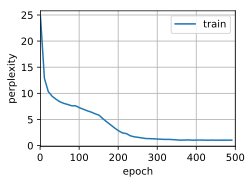

In [13]:
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)